<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера 2</b></font>

Привет еще раз. Спасибо, что доделала работу. Оформление комментариев по работе сохраняется. Только обозначим, что это вторая итерация. 

</div>

# A/B test results assessment


**Задача проекта** — провести оценку результатов A/B-теста.

**Цель проекта**: оценить корректность проведения теста, для этого проверить:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

- Проанализировать результаты теста.

**Техническое задание**

- Название теста: `recommender_system_test`;

- группы: А — контрольная, B — новая платёжная воронка;

- дата запуска: 2020-12-07;

- дата остановки набора новых пользователей: 2020-12-21;

- дата остановки: 2021-01-04;

- аудитория: 15% новых пользователей из региона EU;

- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

- ожидаемое количество участников теста: 6000.

- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

    - конверсии в просмотр карточек товаров — событие `product_page`,

    - просмотры корзины — `product_cart`,

    - покупки — `purchase`.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**ШАГ 1. Импорт библиотек и загрузка данных.**

In [ ]:
import pandas as pd 
import numpy as np
from scipy import stats as st
import math, cmath
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import warnings                                            
warnings.filterwarnings('ignore') 

In [ ]:
marketing_events = (pd.read_csv('.../datasets/ab_project_marketing_events.csv', 
                                parse_dates=['start_dt','finish_dt']))
new_users = pd.read_csv('.../datasets/final_ab_new_users.csv', parse_dates=['first_date'])
ab_events = pd.read_csv('.../datasets/final_ab_events.csv', parse_dates=['event_dt'])
ab_participants = pd.read_csv('.../datasets/final_ab_participants.csv')


**ШАГ 2. Предобработка данных**

Ознакомимся со всеми датасетами.

In [ ]:
df=[marketing_events, new_users, ab_events, ab_participants]
for every in df:
    display(every.head(5))
    print('                                                                 ')
    print(every.info())
    print('                                                                 ')
    print(every.isna().sum())
    print('                                                                 ')
    print(every.duplicated().sum())
    print('                                                                 ')
    display(every.describe())
    print('_________________________________________________________________')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


                                                                 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None
                                                                 
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
                                                                 
0
                                                                 


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,International Women's Day Promo,APAC,2020-02-14 00:00:00,2020-05-11 00:00:00
freq,1,4,1,1
first,NaN,NaN,2020-01-25 00:00:00,2020-02-07 00:00:00
last,NaN,NaN,2020-12-30 00:00:00,2021-01-07 00:00:00


_________________________________________________________________


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


                                                                 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
None
                                                                 
user_id       0
first_date    0
region        0
device        0
dtype: int64
                                                                 
0
                                                                 


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,2D99F6F203195B88,2020-12-21 00:00:00,EU,Android
freq,1,6290,46270,27520
first,NaN,2020-12-07 00:00:00,NaN,NaN
last,NaN,2020-12-23 00:00:00,NaN,NaN


_________________________________________________________________


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


                                                                 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB
None
                                                                 
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
                                                                 
0
                                                                 


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


_________________________________________________________________


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


                                                                 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB
None
                                                                 
user_id    0
group      0
ab_test    0
dtype: int64
                                                                 
0
                                                                 


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,5A435BDA3980EFA3,A,interface_eu_test
freq,2,9655,11567


_________________________________________________________________


Необходимо привести дату к нужному формату.

In [ ]:
print('Дата начала событий:', marketing_events['start_dt'].min())
print('Дата окончания событий:', marketing_events['finish_dt'].max())

Дата начала событий: 2020-01-25 00:00:00
Дата окончания событий: 2021-01-07 00:00:00


In [ ]:
print('Минимальная дата:', new_users['first_date'].min())
print('Максимальная дата:', new_users['first_date'].max())

Минимальная дата: 2020-12-07 00:00:00
Максимальная дата: 2020-12-23 00:00:00


По требованию ТЗ нам необходимы данные только с 7 декабря 2020 по 4 января 2021 года. В таблицах new_users и marketing_events мы имеем данные за более длительный период. Возможных причин может быть несколько: данные выгружены за более длительный период, записаны лишние данные, произшла ошибка при выгрузке. Отфильтруем датасеты, оставив нужные даты.

In [ ]:
new_users = new_users[new_users['first_date'] <= '2020-12-21 00:00:00']

In [ ]:
marketing_events = marketing_events[(marketing_events['start_dt'] <= '2021-01-04') & 
                                          (marketing_events['finish_dt'] >= '2020-12-07')]

В ab_events 377577 пропусков, заполним их нулями, так как у нас отсутствуют дополнительные данные.

In [ ]:
ab_events = ab_events.fillna(0)
ab_events.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

Пропуски отсуттсвуют по всех датасетах. В ab_events пропуски заполнены нулями, в остальных латасетах пропуски отсутствуют. Следует проверить в ab_events столбец details, так как максимальное количество деталей 499. Дата приведена к необходимому формату. Данные отфильтрованы по датам, с которыми требуется дальнейшая работа по ТЗ.


**ШАГ 3. Исследовательский анализ данных.**

**3.1. Общее исследование данных**

In [ ]:
marketing_events['regions'].value_counts()

CIS              1
EU, N.America    1
Name: regions, dtype: int64

После фильтрации по дате у нас остались события из двух регионов: СНГ и США/Европа.

In [ ]:
new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

В ЕС 42340 пользователей.

In [ ]:
marketing_events['name'].value_counts()

Christmas&New Year Promo     1
CIS New Year Gift Lottery    1
Name: name, dtype: int64

Мы имеем 2 типа событий: рождественское и новогоднее промо и новогодняя подарочная лотеря. 



Проверим совпадения с маркетинговыми активностями в тестовый период:

In [ ]:
marketing_events.query('start_dt >= "2020-12-07" & start_dt <= "2021-01-04" | finish_dt >= "2020-12-07" & finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Поскольку тестирование проводится на регионе EU, можно утверждать, что есть одно пересечение - новогодняя/рождественская промоакция, которая может повлиять на результаты. Тестирование не следовало назначать на период, который может совпадать с маркетинговыми активностями и праздниками.

In [ ]:
users_total = len(new_users['user_id'].unique())
print('Всего зарегистрировавшихся пользователей: {}'.format(users_total))

Всего зарегистрировавшихся пользователей: 56470


In [ ]:
participants_total = len(ab_participants['user_id'].unique())
print('Всего участников теста: {}'.format(participants_total))

Всего участников теста: 16666


In [ ]:
print ('Используемые девайсы: {}'.format(new_users['device'].unique()))

Используемые девайсы: ['PC' 'Android' 'iPhone' 'Mac']


In [ ]:
new_users['device'].value_counts()

Android    25161
PC         14310
iPhone     11477
Mac         5522
Name: device, dtype: int64

Посмотим, какие существуют события:

In [ ]:
ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Проверим названия проведенных тестов:

In [ ]:
ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

По ТЗ нам необходим recommender_system_test. Необходимо проверить, есть ли пересечение по пользователям в двух тестах. Сделаем срез данных по recommender_system_test и узнаем число пользователей:

In [ ]:
rs_participants = ab_participants.query('ab_test == "recommender_system_test"')
rs_participants['user_id'].count()

6701

В recommender_system_test 6701 пользователей.

Сделаем срез по тесту interface_eu_test:

In [ ]:
interface_participants = ab_participants.query('ab_test == "interface_eu_test"')
interface_participants['user_id'].count()

11567

Всего участников теста: 16666. Но в ab_participants 18268 записей, то есть мы имеем 1602 пересечения участников теста, которые оказались в 2 группах одновременно, в recommender_system_test и interface_eu_test. 

In [ ]:
events_total = len(ab_events)
print('Всего событий в логе: {}'.format(events_total))

events_total_users = len(ab_events['user_id'].unique())
print('Всего пользователей в логе: {}'.format(events_total_users))
print('Среднее количество событий на пользователя: {}'.format(round(events_total/events_total_users)))

Всего событий в логе: 440317
Всего пользователей в логе: 58703
Среднее количество событий на пользователя: 8


Посчитаем количество записей для каждого события:

In [ ]:
events_count = (ab_events
                .groupby('event_name').agg({'event_dt':'count'})
                .reset_index().sort_values(by = 'event_dt', ascending=False))
events_count.columns = ['event_name', 'events_number']
events_count['ratio_events'] = ((events_count['events_number'] / events_count['events_number'].sum()) * 100).round(1)
display(events_count)

,event_name,events_number,ratio_events
0,login,189552,43.0
2,product_page,125563,28.5
3,purchase,62740,14.2
1,product_cart,62462,14.2


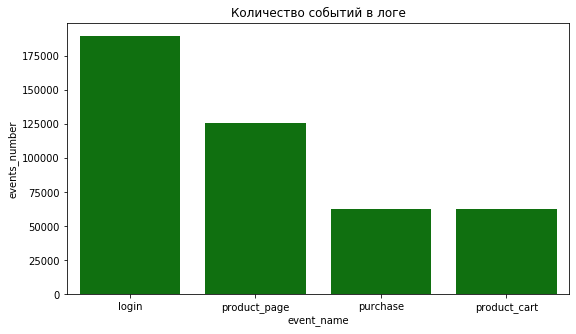

In [ ]:
plt.figure(figsize = (9, 5))
plt.title('Количество событий в логе') 
sns.barplot(x = 'event_name', y = 'events_number', data = events_count, color = 'green')
plt.show()

Всего событий в логе: 440317.

Всего пользователей в логе: 58703.

В среднем на одного пользователя приходится 8 событий.

Отслеживаемые события:

login - вход в систему, чаще всего вызываемое событие в приложении, 185129 раз (43%);

product_page - страница продукта, событие происходило 125563 раз (25,5%);

purchase - покупка, событие происходило 62740 раз (14,2%);

product_cart - корзина продукта, событие происходило 62462 раз (14,2%).

Покупка совершается чаще, чем продукт кладется в корзину.
Пользователи могли пропустить этап корзины, если уже на странице с продуктом есть кнопка оплаты. Предположительно, так проще сделать при покупке 1 товара, и добавление товара в корзину не является обязательным этапом воронки.

**3.2. Исследование конверсии в регионе EU**

Объединим таблицы:

In [ ]:
data = new_users.merge(ab_events, on='user_id', how='left')
data = data.merge(ab_participants, on='user_id', how='left')
display(data.head())

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,0.0,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,0.0,A,recommender_system_test
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,0.0,NaN,NaN
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,0.0,NaN,NaN
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,0.0,NaN,NaN


Отфильтруем только тех пользователей, кто участвовал в A/B-тестировании recommender_system_test (согласно ТЗ). Так мы исключим пересечения с конкурирующими тестами.

In [ ]:
data_eu = data.query('ab_test == "recommender_system_test"')

In [ ]:
data_eu = data_eu.query('region == "EU"')

In [ ]:
data_eu['user_id'].nunique()

6351

In [ ]:
print('Данные по событиям распределены от', data_eu['event_dt'].min(), 'до', data_eu['event_dt'].max())

Данные по событиям распределены от 2020-12-07 00:05:57 до 2020-12-30 12:42:57


Этот временной промежуток меньше, чем требует техзадание. 

Новые пользователи участвовали в тестировании до 2020-12-21.

In [ ]:
data_eu = data_eu.query('first_date <= "2020-12-21"')

Cделаем срез с ограничением даты сограсно ТЗ:

In [ ]:
print('Всего участников тестрования в EU:', len(data_eu['user_id'].unique()))

Всего участников тестрования в EU: 3481


In [ ]:
eu_events_total = len(data_eu)
print('Всего событий в логе: {}'.format(eu_events_total))

events_eu_users = len(data_eu['user_id'].unique())
print('Среднее количество событий на пользователя для EU: {}'.format(round(eu_events_total/events_eu_users)))

Всего событий в логе: 23420
Среднее количество событий на пользователя для EU: 7


In [ ]:
eu_event_counts = data_eu['event_name'].value_counts().reset_index()
eu_event_counts.columns = ['event_name', 'events_number']
display(eu_event_counts)

,event_name,events_number
0,login,10595
1,product_page,6554
2,purchase,3196
3,product_cart,3075


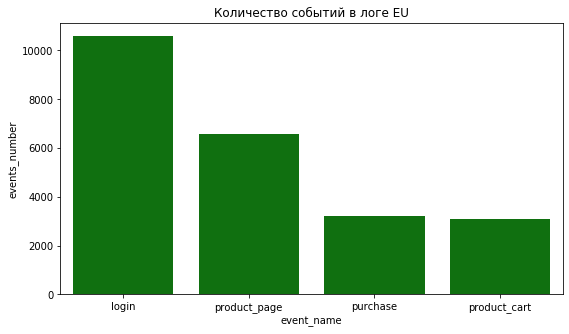

In [ ]:
plt.figure(figsize=(9, 5))
plt.title('Количество событий в логе EU') 
sns.barplot(x = 'event_name', y = 'events_number', data = eu_event_counts, color = 'green')
plt.show()


В этом случае также  больше событий покупок, чем событий входа в корзину. Предположительно, мы имеем дело с ошибками, если только не существует возможности миновать корзину и оплатить заказ сразу.

**Построим воронку событий для региона EU**

In [ ]:
eu_event_funnel = data_eu.groupby('event_name')['user_id'].nunique().sort_values(ascending = False).reset_index()
eu_event_funnel['index'] = [1,2,4,3]
funnel = eu_event_funnel.sort_values(by='index')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Funnel',
    x = funnel['user_id'],
    y = funnel['event_name'],
    
    textinfo = 'value + percent initial + percent previous'))

fig.update_layout(title = 'Воронка событий для региона EU', title_x = 0.5)
fig.show()

Поэтапное описание воронки:

1. Ввели логин 100% пользователей, 3481 чел.

2. 63% пользователей посетили страницу с продуктом, 2178 чел.

3. Добавили товар в козину 29% пользователей, 1026 чел.

4.  Совершили покупку 31% пользователей, 1082 чел., и это количество на 56 человек больше добавивших продукт в корзину. 

2% пользователей пропустили этап корзины.

**Построим воронку с учетом последовательности событий**

В соответствии с ТЗ ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%

In [ ]:
recommender_system_test = data[data['ab_test'] == 'recommender_system_test']
days_14 = recommender_system_test[recommender_system_test['event_dt'] < '2020-12-21']

In [ ]:
first_day = recommender_system_test[recommender_system_test['event_dt'] < '2020-12-08 00:00:00']

In [ ]:
last_day = recommender_system_test[(recommender_system_test['event_dt'] > '2020-12-20 00:00:00') &
                                   (recommender_system_test['event_dt'] < '2020-12-22 00:00:00')]

In [ ]:
first_event_funnel = first_day.groupby('event_name')['user_id'].nunique().sort_values(ascending = False).reset_index()
first_event_funnel['index'] = [1,2,4,3]
first_day_funnel = first_event_funnel.sort_values(by='index')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Funnel',
    x = first_day_funnel['user_id'],
    y = first_day_funnel['event_name'],
    
    textinfo = 'value + percent initial + percent previous'))

fig.update_layout(title = 'Воронка событий первого дня', title_x = 0.5)
fig.show()

Конверсия в product_page равна 64% от login.

Конверсия в product_cart равна 25% от login.

Конверсия в purchase равна 33% от login.


Корзину учитывать не будем, нам важно понимать конверсию от регистрации до покупки, это 33% в первый день.


In [ ]:
last_event_funnel = last_day.groupby('event_name')['user_id'].nunique().sort_values(ascending = False).reset_index()
last_event_funnel['index'] = [1,2,4,3]
last_day_funnel = last_event_funnel.sort_values(by='index')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Funnel',
    x = last_day_funnel['user_id'],
    y = last_day_funnel['event_name'],
    
    textinfo = 'value + percent initial + percent previous'))

fig.update_layout(title = 'Воронка событий 14-го дня', title_x = 0.5)
fig.show()

Конверсия в product_page равна 62% от login.

Конверсия в purchase равна 31% от login.

Конверсия в product_cart равна 28% от login.

33% конверсии от регистрации до покупки в первый день и 31% в 14-ый день.

Таким образом, ожидаемый эффект конверсии не достигнут, наоборот, конверсия упала.

**3.3. Проверим, какая доля пользователей из региона EU**

Сделаем новую таблицу, где будут пользователи из ЕС по тесту recommendation_system

In [ ]:
eu_new_users = len(new_users.query('region == "EU"')) 

ab_test_data = pd.merge(rs_participants, new_users, on='user_id') 

real_eu_users = ab_test_data.groupby('region').agg({'user_id':'nunique'}).loc['EU', 'user_id']
x = real_eu_users/eu_new_users
print('Доля новых пользователей из региона EU: {:.0%}'.format(x))

Доля новых пользователей из региона EU: 14%


 В выборку попало 15% новых пользователей из региона EU, это соответствует ТЗ.

**3.4. Посчитаем количество пользователей в каждой тестовой группе**

In [ ]:
group_users_count = (
    rs_participants.groupby('group')
    .agg({'user_id': ['nunique']})
    .reset_index().sort_values(by= ('user_id', 'nunique'), ascending=False)
)
group_users_count.columns = ['group', 'users_number']
display(group_users_count)

,group,users_number
0,A,3824
1,B,2877


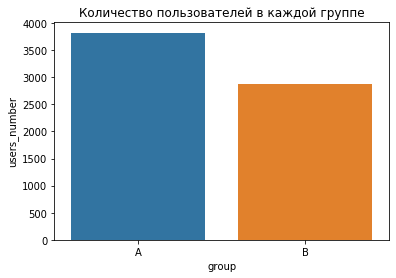

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Количество пользователей в каждой группе') 
sns.barplot(x = 'group', y = 'users_number', data = group_users_count)
plt.show()


В recommender_system_test:

Группа: А (контрольная): 3824 пользователей.

Группа: B (новая платёжная воронка): 2877 пользователей.

**3.5. Сравним группы А и В**

Выясним, сколько в каждой группе событий на пользователя. 

In [ ]:
ab_events = ab_events.query('event_dt <= "2020-12-29"')

In [ ]:
ab_test_data = pd.merge(ab_test_data, ab_events, on='user_id')
display(ab_test_data.head())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,0.00
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00


In [ ]:
group_A = ab_test_data.query('group == "A"')
group_B = ab_test_data.query('group == "B"')

In [ ]:
A_mean = (group_A.pivot_table (index = ['user_id', 'event_name'], 
                                     values = 'event_dt', aggfunc = 'count').reset_index()
                                     .groupby('event_name')
                                     .agg({'event_dt':'mean'}).reset_index().round(2)
)
                    
print ('Cреднее количество пользователей в группе А')
display(A_mean)

Cреднее количество пользователей в группе А


,event_name,event_dt
0,login,3.05
1,product_cart,3.04
2,product_page,3.03
3,purchase,2.99


In [ ]:
B_mean = (group_B.pivot_table (index = ['user_id', 'event_name'], 
                                     values = 'event_dt', aggfunc = 'count').reset_index()
                                     .groupby('event_name')
                                     .agg({'event_dt':'mean'}).reset_index().round(2)
)
print ('Cреднее количество пользователей в группе В')
display(B_mean)


Cреднее количество пользователей в группе В


,event_name,event_dt
0,login,2.78
1,product_cart,2.67
2,product_page,2.65
3,purchase,2.59


In [ ]:
event_A = group_A.pivot_table (index = ['user_id'], values = 'event_name', aggfunc = 'count').reset_index()
event_B = group_B.pivot_table (index = ['user_id'], values = 'event_name', aggfunc = 'count').reset_index() 

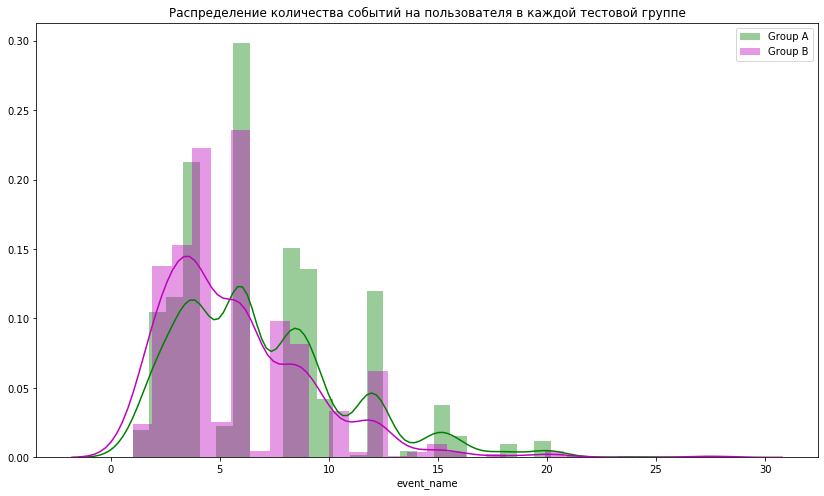

In [ ]:
plt.figure(figsize=(14, 8))
sns.distplot(event_A['event_name'], bins=30, color='g')
sns.distplot(event_B['event_name'], bins=30, color = 'm')
plt.legend(labels = ('Group A', 'Group B'))
plt.title('Распределение количества событий на пользователя в каждой тестовой группе')
plt.show()

In [ ]:
print('Среднее число событий в группе А {}'.format(event_A['event_name'].mean().round(2)))
print('Среднее число событий в группе B {}'.format(event_B['event_name'].mean().round(2)))

Среднее число событий в группе А 6.87
Среднее число событий в группе B 5.73


In [ ]:
event_A.describe()

,event_name
count,2747.000000
mean,6.870404
std,3.829575
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [ ]:
event_B.describe()

,event_name
count,928.000000
mean,5.725216
std,3.434851
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,28.000000


Выборки обладают различным распределением взаимодействий, а так же разными средним количеством событий на одного пользователя. Количество событий на пользователя выше в группе А, в среднем 6,87 событий на пользователя, в то время как в группе В 5,73 события.

**3.6. Проверим пересечение пользователей в тестовых группах**

In [ ]:
len(np.intersect1d(rs_participants.query('group == "A"')['user_id'].unique(), rs_participants.query('group == "B"')['user_id'].unique()))

0

Пересечений пользователей в группах А и В в recommender_system_test нет.

Провереим на пересечение пользователей из recommender_system_test с конкурирующими тестами.

In [ ]:
test_intersection = len(np.intersect1d(ab_participants.query('ab_test == "recommender_system_test"')['user_id'].unique(), 
ab_participants.query('ab_test == "interface_eu_test"')['user_id'].unique()))
test_intersection

1602

1602 уникальных пользователя попали одновременно в разные тесты.

In [ ]:
len(np.intersect1d(ab_participants.query('ab_test == "recommender_system_test" & group == "B"')['user_id'].unique(), \
ab_participants.query('ab_test == "interface_eu_test" & group == "B"')['user_id'].unique()))

344

344 пользователя из группы В попало в разные тесты.

Таким образом, мы видим некорректное разбиение пользователей на группы, так как 1602 человека попали в разные тесты, а 344 пользователя попали в экспериментальные группы разных тестов.

**3.7. Посмотрим, как события распределены по дням.**

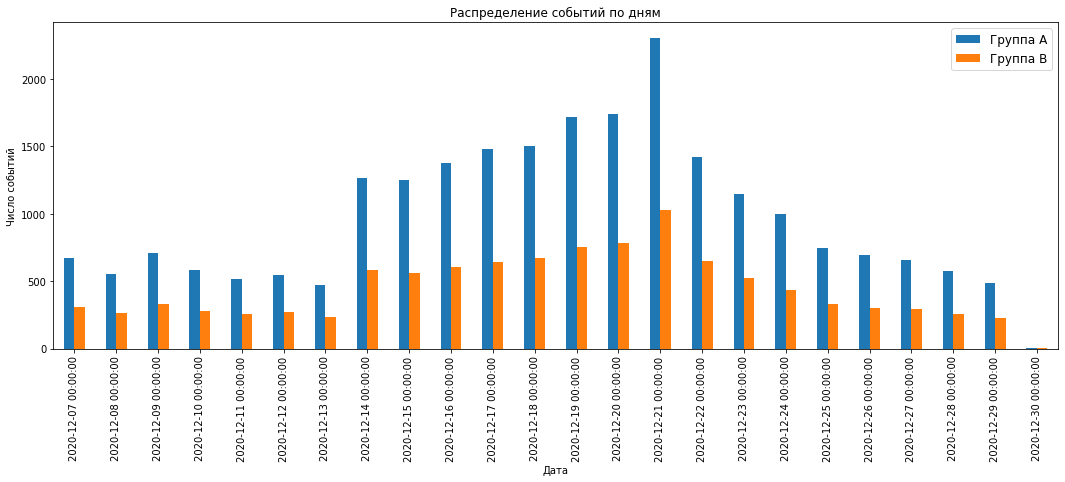

In [ ]:
data_eu['date'] = data_eu['event_dt'].dt.date.astype('datetime64')
data_eu.groupby('date').agg({'user_id': ['count','nunique']}).plot(kind='bar', figsize=(18, 6),legend = False)
plt.legend(['Группа A', 'Группа B'], prop={'size':12})
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.title('Распределение событий по дням')
plt.show()

С 7 по 13 декабря происходит 500-600 событий. 14 декабря случается резкий скачок до 1400 событий. Рост продолжается и достигает пика 21 декабря. Так как регион EU, то это может быть связано с рождественскими акциями. С 22 декабря происходит резкий спад, который стабилизируется 25.12. 30 декабря мы видим почти нулевую активность. Возможно, неполадки в системе.

Посмотрим, как распределились события по дням в группе А.

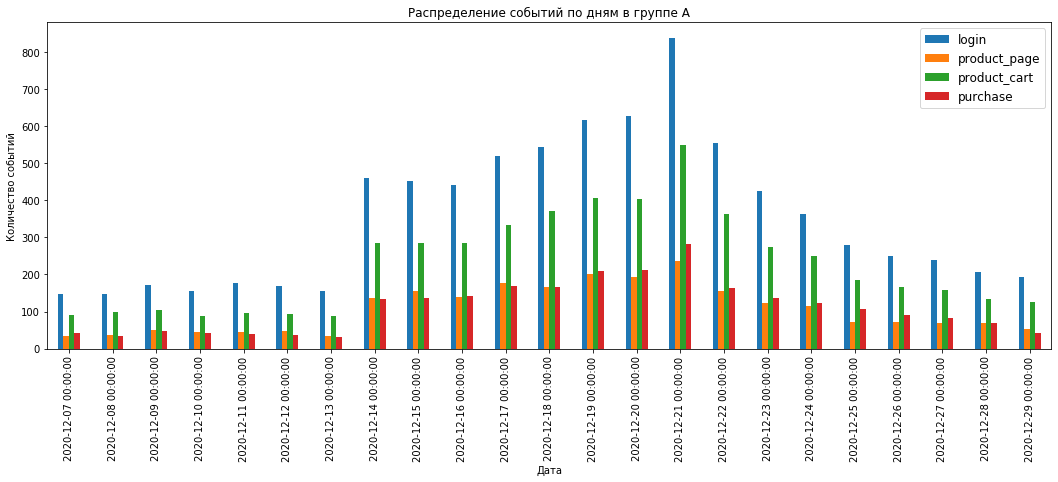

In [ ]:
(data_eu[data_eu['group'] == 'A']
 .groupby(['date', 'event_name'])
 .agg({'user_id': ['count']}).unstack()
 .plot(kind = 'bar', figsize =(18, 6), title = 'Распределение событий по дням в группе А')
)
plt.legend(['login', 'product_page', 'product_cart', 'purchase'], prop={'size':12})
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()


Посмотрим, как распределились события по дням в группе B.

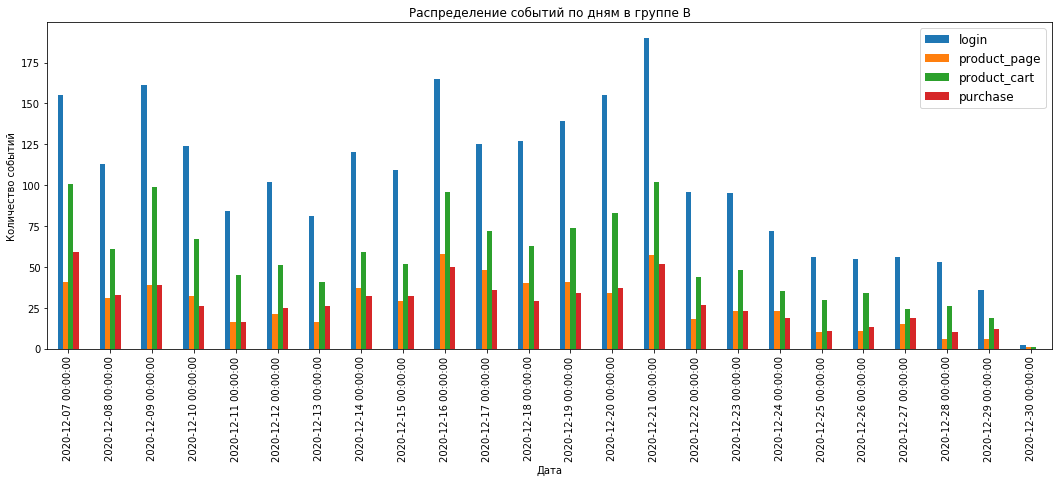

In [ ]:
(data_eu[data_eu['group'] == 'B']
 .groupby(['date', 'event_name'])
 .agg({'user_id': ['count']}).unstack()
 .plot(kind = 'bar', figsize =(18, 6), title = 'Распределение событий по дням в группе B')
)
plt.legend(['login', 'product_page', 'product_cart', 'purchase'], prop={'size':12})
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()


Наглядно видно, насколько в больше событий в группе А, чем в группе В.

Всего участников теста: 16666.

Всего участников тестрования в EU: 3481.

Всего событий в логе по по всем регионам: 440317.

Всего событий в логе для региона EU: 23420.

Среднее количество событий на пользователя для EU: 7.

Доля пользователей из EU: 15%.

Всего пользователей в логе: 58703.

Среднее количество событий на пользователя по всем регионам: 8.

Используемые девайсы: PC, Android, iPhone, Mac.

Исследуемые события: login, product_page, product_cart, purchase.

Проведенные тесты: recommender_system_test (6701 пользователь), interface_eu_test (11567 пользователей). 

В recommender_system_test:

Группа: А (контрольная): 3824 пользователей.

Группа: B (новая платёжная воронка): 2877 пользователей.

 
Мы имеем 2 типа маркетинговых событий: рождественское и новогоднее промо и новогодняя подарочная лотерея.

Поскольку тестирование проводится на регионе EU, можно утверждать, что есть одно пересечение - новогодняя/рождественская промоакция, которая может повлиять на результаты. Тестирование не следовало назначать на период, который может совпадать с маркетинговыми активностями и праздниками.

По европейскому региону данные по событиям распределены от 2020-12-07 00:05:57 до 2020-12-30 12:42:57. Этот временной промежуток меньше, чем требует техзадание.

Маркетинговая воронка по всем регионам:

login - вход в систему, чаще всего вызываемое событие в приложении, 185129 раз (43%);

product_page - страница продукта, событие происходило 125563 раз (25,5%);

purchase - покупка, событие происходило 62740 раз (14,2%);

product_cart - корзина продукта, событие происходило 62462 раз (14,2%).

Покупка совершается чаще, чем продукт кладется в корзину, на 278 раз. 
 
Маркетинговая воронка по региону EU:
 
Ввели логин 100% пользователей, 3481 чел.

63% пользователей посетили страницу с продуктом, 2178 чел.

Добавили товар в козину 29% пользователей, 1026 чел.

Совершили покупку 31% пользователей, 1082 чел., и это количество на 56 человек больше добавивших продукт в корзину.

2% пользователей могли пропустить этап корзины, если уже на странице с продуктом есть кнопка оплаты. Предположительно, так проще сделать при покупке 1 товара, и добавление товара в корзину не является обязательным этапом воронки.
 
За 14 дней ожидаемый эффект конверсии в 10% не достигнут, наоборот, конверсия упала.
 
Выборки обладают различным распределением взаимодействий, а так же разными средним количеством событий на одного пользователя. Количество событий на пользователя выше в группе А.
 
Мы увидели некорректное разбиение пользователей на группы, так как 1602 человека попали в разные тесты, а 344 пользователя попали в экспериментальные группы разных тестов.
 
События по дням распределились таким образом, что  с 14 декабря наблюдается  резкий скачок событий, их стало в 1,5 раза больше. Рост продолжается и достигает пика 21 декабря. Так как регион EU, то это может быть связано с рождественскими акциями. С 22 декабря происходит резкий спад, который стабилизируется 25 декабря. 30 декабря мы видим почти нулевую активность. Возможно, неполадки в системе.


**ШАГ 4. Проверка статистических гипотез**

Проверим гипотезы:

Гипотеза H0:  нет статистически значимой разницы между конверсиями в группе А и в группе B.

Гипотеза H1: есть статистически значимая разница между конверсиями в группе А и в группе B.

In [ ]:
recommender_system_test = recommender_system_test[recommender_system_test['event_dt'] < '2020-12-25 00:00:00']
#recommender_system_test попал в пересечение с Christmas&New Year Promо. 
#Тест и Promо имеют пересечение в 5 дней (25-30 декабря, мы имеем данные только до 30 числа)


In [ ]:
exp = recommender_system_test.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique')\
                       .sort_values('A',ascending=False)
display(exp)

group,A,B
event_name,,
login,2747,927
product_page,1780,523
purchase,872,256
product_cart,824,255


In [ ]:
users = recommender_system_test.groupby('group')['user_id'].nunique().reset_index()
users = users.set_index(users.columns[0])
display(users)

,user_id
group,
A,2747
B,928


Для проверки гипотез с множественным сравнением воспользуемся Z-критерием и поправкой Бонферрони для 4 сравнений.

In [ ]:
def print_z_test_with_bonferroni_validation_result(group1, group2, event, alpha): 
    p1_event = exp.loc[event, group1]
    p2_event = exp.loc[event, group2] 
    p1_users = users.loc[group1, 'user_id'] 
    p2_users = users.loc[group2, 'user_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    bonferroni_alpha = alpha / 4
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(group1, group2, event, p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу о равенстве конверсии в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах")

In [ ]:
for event in exp.index:
    print_z_test_with_bonferroni_validation_result('A', 'B', event, 0.05)
    print()


Проверка для групп A и B, событие: login, p-значение: 0.09
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для групп A и B, событие: product_page, p-значение: 0.00
Отвергаем нулевую гипотезу о равенстве конверсии в группах

Проверка для групп A и B, событие: purchase, p-значение: 0.02
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для групп A и B, событие: product_cart, p-значение: 0.15
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах



Есть статистически значимая разница между конверсией для события product_page в группах А и В. Для остальных событий разницы нет. Это означает, что изменения, связанные с внедрением улучшенной рекомендательной системы, не принесли роста конверсии на целевом этапе покупки или корзины.

**ОБЩИЙ ВЫВОД**

Тест был проведен с большим количеством нарушений, и его результаты не должны считаться валидными.
 
Какие **особенности проведения А/В теста не были учтены** в данном тестировании или негативно повлияли на его проведение:
 
-Длительность эксперимента и проведения теста,выгрузка лишних данных. Пользователи набирались в группы с 7 по 23 декабря 2020 года, хотя окончание набора пользователей было запланировано на 21 декабря. Также  тестирование доджно было проводиться с 7 декабря по 30 декабря 2020 года, хотя в ТЗ указано, что проведение теста было запланировано с 7 декабря 2020 по 4 января 2021 года. Не хватает данных за 5 дней. Это может означать как то, что тест остановлен слишком рано, так и то, что были выгружены не все данные.
 
-Проведение теста пересекается с проведением других тестов. Тест на улучшение рекомендательной системы и тест на работу  интерфейса проводились одновременно.
 
-Проведение теста пересекается с маркетинговыми событиями в течение 5 дней, оно совпадает с рождественским/новогодним сезоном праздников.

-Различие ключевых метрик по группам имеет статистическую значимость.

-Наличие технических сбоев, например, за 30 декабря события практически на нуле.

-Некорректное распределение выборок, ошибки при формировании групп и наборе участников для проведения теста. Численность участников контрольной группы в разы выше численности участников экспериментальной группы. 

-Группы обладают различным распределением взаимодействий и разными средним количеством событий на одного пользователя.

-Количества участников в  выборках недостаточно, чтобы зарегистрировать значимые изменения. Так, согласно поставленному тех.заданию, нам необходимо 6000 участников, а имелось только 3481.

-В воронках ожидаемый результат в увеличении конверсии по каждому шагу на 10% не достигнут. С учетом последовательности событий от первого события до покупки доходит 0% пользователей. Есть статистически значимая разница между конверсией для события product_page в группах А и В. Для остальных событий разницы нет. Это также означает, что изменения, связанные с внедрением улучшенной рекомендательной системы, не принесли роста конверсии на целевом этапе покупки или корзины.

**РЕКОМЕНДАЦИИ:** необходимо учесть все вышеперечисленные недочеты и провести тест заново.
